**Implementation of transformer, - testing on the English-French dataset and Movielines**
- Use d2l tutorial and my implementation for comparision
- Drive mnt: mount drive and get data, set up vocab
- packages: Install dependencies
- D2l: use d2l packages & my own seq2seq, guides included 
- Use pretrained tokenizers for Movielines and self-erected Vocab for the Eng~Fre

#D2l

In [ ]:
!pip install -q d2l==1.0.0-alpha0 matplotlib_inline #d2l packages

     |████████████████████████████████| 92 kB 1.0 MB/s 
     |████████████████████████████████| 120 kB 19.2 MB/s 
     |████████████████████████████████| 1.6 MB 69.0 MB/s 
     |████████████████████████████████| 82 kB 585 kB/s 


In [ ]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
#d2l PositionwiseFFN and AddNorm
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [ ]:
#D2l encoder
class TransformerEncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
class TransformerEncoder(nn.Module):
    """Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X):
        valid_lens = torch.tensor(X.shape[1], dtype=torch.long).repeat(X.shape[0])
        # print("valid", valid_lens.shape)
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X, valid_lens

In [ ]:
#D2l Decoder
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
#Seq2Seq for aggregating encoder and decoder
class Seq2Seq(nn.Module):
    #aggregation OOP
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, y):
        '''
        output when testing: '<sos>'
        '''
        x, valid = self.encoder(x)
        #encoder: b x n x d
        state = self.decoder.init_state(x, valid)
        #decoder:
        outputs, state = self.decoder(y, state)
        return outputs, state

In [ ]:
#test d2l modules 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
src, tgt = torch.ones(16, 15, dtype=torch.long).to(device), torch.zeros(16, 13, dtype=torch.long).to(device)
valid_lens = torch.ones(128)
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5).to(device)
decoder = TransformerDecoder(200, 24, 48, 8, 2, 0.5).to(device)
encoder_output = encoder(src)
encoder_output[0].shape
#modify the torch.py, add .to(X.device) to run tutorials

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([16, 15, 24])

In [ ]:
#seq2seq d2l
seq2seq = Seq2Seq(encoder, decoder)
seq2seq(src, tgt)[0].shape

torch.Size([16, 13, 200])

## my model

In [ ]:
%env dir=/content/deep-learning/NLP/implement/temp

env: dir=/content/deep-learning/NLP/implement/temp


In [ ]:
#Dataset and train, validation script 
import sys
import time
import random
from copy import deepcopy
import pandas as pd
import os
from sklearn.model_selection import train_test_split
PATH = os.environ['dir']
sys.path.append(PATH + "/src")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
import torch.nn as nn
import pytorch_lightning as pl
import wandb
import hydra
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader




'''
- pl_module
- simple torch script for debug
''' 
train_loss = []
val_loss = []

#dataset
class ChatDataset(Dataset):
    def __init__(self, data, batch=32, max_length=10):
        super().__init__()
        self.data = data
        self.max_length = max_length
        self.batch = batch
    def __getitem__(self, idx):
        src, tgt = self.data.iloc[idx, :]

        src = '[BOS] ' + src + ' [EOS]'
        tgt = '[BOS] ' + tgt + ' [EOS]'      
        #get the tensor word:
        #drop the [CLS] token and [SEP]
        #current tokenizer, MAX_LEN + 2 -> drop CLS and SEP token later ? ``
        while len(engVocab.tokenize(src)) < self.max_length + 2:
            src += ' [PAD]'
        while len(frVocab.tokenize(tgt)) < self.max_length + 2:
            tgt += ' [PAD]'
        src_token = torch.tensor(engVocab.tokenize(src), dtype=torch.long)
        tgt_token = torch.tensor(frVocab.tokenize(tgt), dtype=torch.long)

        if len(src_token) > self.max_length:
            src_token = src_token[:self.max_length]
        if len(tgt_token) > self.max_length:
            tgt_token = tgt_token[:self.max_length]
        src_token, tgt_token = src_token, tgt_token   
       




        return src_token, tgt_token

    def __len__(self):
        return len(self.data)
class ChatMachine(pl.LightningModule):
    '''
    lightning module for dataloader, training and testing
    '''
    def __init__(self, lr, mode='teacher_forcing'):
        super().__init__()
        self.encoder = Encoder(vocab=VOCAB_SIZE, n_seq=MAX_LEN, d_model=512, d_ff=2048, h=8, N=6, p_drop=0.1, label_smoothing=None)
        self.decoder = Decoder(vocab=VOCAB_SIZE, n_seq=MAX_LEN-1, d_model=512, d_ff=2048, h=8, N=6, p_drop=0.1, label_smoothing=None)
        self.model = Seq2Seq(self.encoder, self.decoder)
        self.save_hyperparameters()


    def training_step(self, batch, batch_idx):
        src, tgt = batch
        decoder_input, decoder_output = deepcopy(tgt[:, :-1]), deepcopy(tgt[:, 1:])
        pred = self.model(src, decoder_input)[0]

        #teacher forcing a.k.a use default ground truth (use current word -> next word) 
        if self.hparams.mode == "teacher_forcing":
            loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
            pred_tokens = torch.argmax(pred, dim=-1)
            self.log("train loss", loss)
            return loss
        #uniform random sampling, iterate through the n_seq of target
        else:
            pred_tokens = torch.argmax(pred, dim=-1)
            for i in range(tgt[:, :-1].shape[1]):
                p = random.uniform(0, 1)
                if p > 0.69:
                    decoder_input[:, i] = pred_tokens[:, i]
            pred = self.model(src, decoder_input)[0]
            loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
            pred_tokens = torch.argmax(pred, dim=-1)
            self.log("train loss", loss)
            return loss
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        return {'optimizer': optimizer}


def train(train_dataloader, val_dataloader, model, mode='teacher_forcing', device = 'cuda' if torch.cuda.is_available() else 'cpu', lr=1e-3):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    model.train()
    for i in range(10):
        trainloss = 0
        valloss = 0
        for src, tgt in train_dataloader:
            # start = time.time()
            optimizer.zero_grad()
            src, tgt = src.to(device), tgt.to(device)
            decoder_input, decoder_output = deepcopy(tgt[:, :-1]), deepcopy(tgt[:, 1:])
            pred = model(src, decoder_input)[0]
            if mode == "teacher_forcing":
                loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
                pred_tokens = torch.argmax(pred, dim=-1)
            #uniform random sampling, iterate through the n_seq of target
            else:
                pred_tokens = torch.argmax(pred, dim=-1)
                for i in range(tgt[:, :-1].shape[1]):
                    p = random.uniform(0, 1)
                    if p > 0.69:
                        decoder_input[:, i] = pred_tokens[:, i]
                pred = model(src, decoder_input)[0]
                loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
                pred_tokens = torch.argmax(pred, dim=-1)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()
            # print("passed", time.time() - start)
            
            # if len(train_loss) % 50 == 0:
        
        with torch.no_grad():
          for src, tgt in val_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            decoder_input, decoder_output = deepcopy(tgt[:, :-1]), deepcopy(tgt[:, 1:])
            pred = model(src, decoder_input)[0]
            loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
            valloss += loss.item()
          val_loss.append(valloss)
          train_loss.append(trainloss)
          print(f'{i}:', trainloss, valloss)


        

                    
                
        



    


In [ ]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import pytorch_lightning as pl
import wandb
import hydra
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import sys
PATH = os.environ['dir']
sys.path.append(PATH + "/src")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from utils import MaskedNLL
MAX_LEN = 15
dataset = ChatDataset(data)
train_data, val_data = train_test_split(data, test_size=0.3)
train_dataset = ChatDataset(train_data, max_length=MAX_LEN)
val_dataset = ChatDataset(val_data, max_length=MAX_LEN)
src_token, tgt_token = train_dataset[0]
# train_dataset, val_dataset = train_test_split(dataset, test_size=0.3)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, drop_last=True)
src, tgt = iter(train_dataloader).next()
# # src, tgt
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4


In [ ]:
#if we use the d2l modules
# encoder = TransformerEncoder(
#     engVocab.num_words, num_hiddens, ffn_num_hiddens, num_heads,
#     num_blks, dropout)
# decoder = TransformerDecoder(
#     frVocab.num_words, num_hiddens, ffn_num_hiddens, num_heads,
#     num_blks, dropout)
# seq2seq = Seq2Seq(encoder, decoder)

In [ ]:
#if use my model, run it 
from models.modules import Seq2Seq, Encoder, Decoder
encoder = Encoder(vocab=engVocab.num_words, n_seq=MAX_LEN, d_model=256, d_ff=64, h=4, N=2, p_drop=0.1, label_smoothing=None)
decoder = Decoder(vocab=frVocab.num_words, n_seq=MAX_LEN-1, d_model=256, d_ff=64, h=4, N=2, p_drop=0.1, label_smoothing=None)
seq2seq = Seq2Seq(encoder, decoder)
print("sanity check", seq2seq(src, tgt[:, 1:3])[0].shape)

In [ ]:
train(train_dataloader, val_dataloader, seq2seq)

In [ ]:
valloss = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq2seq.to(device)
seq2seq.train()

for src, tgt in train_dataloader:
  src, tgt = src.to(device), tgt.to(device)
  decoder_input, decoder_output = deepcopy(tgt[:, :-1]), deepcopy(tgt[:, 1:])
  pred = seq2seq(src, decoder_input)[0]
  loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
  valloss += loss.item()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
  for src, tgt in val_dataloader:
      # start = time.time()
      src, tgt = src.to(device), tgt.to(device)
      decoder_input, decoder_output = deepcopy(tgt[:, :-1]), deepcopy(tgt[:, 1:])
      pred = seq2seq(src, decoder_input)[0]
      loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
      pred_tokens = torch.argmax(pred, dim=-1)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_loss)

In [ ]:
seq2seq.eval().cuda()
idx = 123
src.shape, tgt.shape

(torch.Size([10]), torch.Size([10]))

In [ ]:
src, tgt = dataset[1]

In [ ]:
' '.join([frVocab.idx2word[i.item()] for i in tgt]), ' '.join([engVocab.idx2word[i.item()] for i in src])

('[BOS] salut ! [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[BOS] hi . [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]')

In [ ]:
output = torch.argmax(seq2seq(src.unsqueeze(0).cuda(), tgt[:-1].unsqueeze(0).cuda())[0], dim=-1).view(-1)

In [ ]:
' '.join([frVocab.idx2word[i.item()] for i in output]), ' '.join([frVocab.idx2word[i.item()] for i in tgt])

('salut . [EOS] . ! ! . . !',
 '[BOS] salut ! [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]')

#DRIVE mnt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/text_eng_fr.csv /content

In [ ]:
!zip -r data_eng_fr.zip /content/text_eng_fr.csv

  adding: content/text_eng_fr.csv (deflated 72%)


In [ ]:
#only unzip if file uploaded
!unzip /content/data_eng_fr.zip -d /content

Archive:  /content/data_eng_fr.zip
  inflating: /content/content/text_eng_fr.csv  


In [ ]:
#build vocab for sample dataset
import os
import pandas as pd
import numpy as np



import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer

import numpy as np 
import re
import nltk
import string
import pandas as pd
import time 

import torch
import torch.nn.functional as F
import torch.nn as nn





nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#vocab prepare class
class Vocab:
    def __init__(self, name=None):
        self.name = name
        self.word2idx = {"[PAD]": 0, "[BOS]": 1, "[EOS]": 2}
        self.idx2word = {0: "[PAD]", 1: "[BOS]", 2: "[EOS]"} #3 special keywords
        self.num_words = 3
        self.word_counts = {} #SOS, EOS, PAD
    def tokenize(self, sentence):
        tokens = []
        for word in sentence.split():
          tokens.append(self.word2idx[word])
        return tokens

    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)
    def add_word(self, word):
        if word in self.word2idx.keys():
            self.word_counts[word] += 1
        else:
            self.word2idx[word] = self.num_words
            self.idx2word[self.num_words] = word
            self.word_counts[word] = 1 
            self.num_words += 1

#normalize words class 
class normalize_funcs:
    def __init__(self, rareword=None):
        self.punctuation = string.punctuation
        self.rareword = rareword
    def lower_case(self, text):
        return text.lower()

    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', self.punctuation))

    def remove_rareword(self, text):
        return ' '.join(word for word in text.split() if word not in self.rareword)
    #trimming pair of source and target
    def trimming(self, input, target, min_freq=1):
        counter = {}
        for arg in [input, target]:
            for line in arg:
                for word in line.split():
                    if word in counter:
                        counter[word] += 1
                    else:
                        counter[word] = 1
        #min freq = 3
        rare_words = []

        
        for key, value in counter.items():
            if value < min_freq:
                rare_words.append(key)
        print("RARE", len(rare_words), len(counter.keys())) 
        #trimming
        new_input = []
        new_target = []
        for line1, line2 in zip(input, target):
            # for word in rare_words:
            #     if word in line1:
            #         line1 = line1.replace(word, "")
            #     if word in line2:
            #         line2 = line2.replace(word, "")
                    
    
            new_input.append(line1.strip())
            new_target.append(line2.strip())
        return new_input, new_target

In [ ]:
#sample data english -> france
data = pd.read_csv("/content/content/text_eng_fr.csv")

In [ ]:
engVocab = Vocab("English")
frVocab = Vocab("French")

In [ ]:
for i in range(len(data)):
  src, tgt = data.iloc[i][['src', 'tgt']]
  engVocab.add_sentence(src)
  frVocab.add_sentence(tgt)
  

In [ ]:
engVocab.tokenize("[BOS] go . [EOS]"), engVocab.num_words, frVocab.num_words

([1, 3, 4, 2], 14883, 29345)

#Env

In [ ]:
!git clone https://github.com/baochi0212/deep-learning

Cloning into 'deep-learning'...
remote: Enumerating objects: 539, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 539 (delta 77), reused 127 (delta 61), pack-reused 390
Receiving objects: 100% (539/539), 18.45 MiB | 7.45 MiB/s, done.
Resolving deltas: 100% (258/258), done.


In [ ]:
%cd deep-learning

/content/deep-learning


In [ ]:
!git pull

Already up to date.


In [ ]:
!git branch

* master


In [ ]:
!git checkout NLP/feature/implement/transformer

Branch 'NLP/feature/implement/transformer' set up to track remote branch 'NLP/feature/implement/transformer' from 'origin'.
Switched to a new branch 'NLP/feature/implement/transformer'


In [ ]:
%cd NLP/implement/temp

/content/deep-learning/NLP/implement/temp


In [ ]:
!pwd

/content/deep-learning/NLP/implement/temp


In [ ]:
%env dir=/content/deep-learning/NLP/implement/temp

env: dir=/content/deep-learning/NLP/implement/temp


In [ ]:
import os
print(os.environ['dir'])

/content/deep-learning/NLP/implement/temp


#packages

In [ ]:
!pip install -q wandb transformers pytorch_lightning hydra-core einops

     |████████████████████████████████| 1.8 MB 10.1 MB/s 
     |████████████████████████████████| 4.7 MB 50.3 MB/s 
     |████████████████████████████████| 705 kB 69.0 MB/s 
     |████████████████████████████████| 151 kB 18.0 MB/s 
     |████████████████████████████████| 157 kB 71.5 MB/s 
     |████████████████████████████████| 181 kB 73.1 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 157 kB 71.3 MB/s 
     |████████████████████████████████| 157 kB 59.2 MB/s 
     |████████████████████████████████| 157 kB 79.8 MB/s 
     |████████████████████████████████| 157 kB 78.6 MB/s 
     |████████████████████████████████| 156 kB 80.5 MB/s 
     |████████████████████████████████| 6.6 MB 39.5 MB/s 
     |████████████████████████████████| 101 kB 12.2 MB/s 
     |████████████████████████████████| 419 kB 74.9 MB/s 
     |████████████████████████████████| 5.9 MB 50.9 MB/s 
     |████████████████████████████████| 117 kB 74.7 MB/s 
     |██████████

In [ ]:
!wandb login #2d91e76209897f5a66538d84313115d103f06dd9

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%cd /content/deep-learning/NLP/implement/temp/data

/content/deep-learning/NLP/implement/temp/data


In [ ]:
!bash download_data.sh

--2022-08-11 14:28:10--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  24.3MB/s    in 0.4s    

2022-08-11 14:28:11 (24.3 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]

Archive:  raw/cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell mo

In [ ]:
!python /content/deep-learning/NLP/implement/temp/src/dataset/preprocess.py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Expressing my opinion is not a terrorist action.

----INPUT, TARGET Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again. Well, I thought we'd start with pronunciation, if that's okay with you.

RARE 0 62429
----data                                                    input                                    target
0             gosh if only we could find kat a boyfriend                  let me see what i can do
1                           cesc ma tete this is my head      right  see  youre ready for the quiz
2                                                  there                                     where
3                       you have my word  as a gentleman                               youre sweet
4                                                     hi  looks like things worked out tonight hu

In [ ]:
!python /content/deep-learning/NLP/implement/temp/src/dataset/dataset.py

Df                                                    input                                    target
0             gosh if only we could find kat a boyfriend                  let me see what i can do
1                           cesc ma tete this is my head      right  see  youre ready for the quiz
2                                                  there                                     where
3                       you have my word  as a gentleman                               youre sweet
4                                                     hi  looks like things worked out tonight huh
...                                                  ...                                       ...
64956                         what oclock is it mr noggs                  eleven oclock my lorj 42
64957     are you dictating the strategy of this war sir                  im explaining my reasons
64958                                             stuart                                       yes
64959  

In [ ]:
!python /content/deep-learning/NLP/implement/temp/src/models/main.py

In [ ]:
!python /content/deep-learning/NLP/implement/temp/src/models/modules.py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
bf PE tensor(0.0220, device='cuda:0')
grad checking True False
Attention Block tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5080, 0.4920, 0.0000, 0.0000, 0.0000],
        [0.3428, 0.3168, 0.3405, 0.0000, 0.0000],
        [0.2479, 0.2485, 0.2501, 0.2535, 0.0000],
        [0.1992, 0.1981, 0.2006, 0.2014, 0.2008]], device='cuda:0',
       grad_fn=<SelectBackward0>)
af PE tensor(-0.9265, device='cuda:0')
seq2seq torch.Size([1, 4, 10000]) cuda:0


#train 

In [ ]:
import sys
import random
from copy import deepcopy
import pandas as pd
import os
from sklearn.model_selection import train_test_split
PATH = os.environ['dir']
sys.path.append(PATH + "/src")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
import torch.nn as nn
import pytorch_lightning as pl
import wandb
import hydra
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader



from dataset.dataset import ChatDataset
from models.modules import Seq2Seq, Encoder, Decoder
from utils import MaskedNLL
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
special_tokens_dict = {'additional_special_tokens': ['[SOS]','[EOS]']}
tokenizer.add_special_tokens(special_tokens_dict)

'''
- pl_module
- simple torch script for debug
''' 
total_loss = []

class ChatMachine(pl.LightningModule):
    '''
    lightning module for dataloader, training and testing
    '''
    def __init__(self, lr, mode='teacher_forcing'):
        super().__init__()
        self.encoder = Encoder(vocab=VOCAB_SIZE, n_seq=MAX_LEN, d_model=512, d_ff=2048, h=8, N=6, p_drop=0.1, label_smoothing=None)
        self.decoder = Decoder(vocab=VOCAB_SIZE, n_seq=MAX_LEN-1, d_model=512, d_ff=2048, h=8, N=6, p_drop=0.1, label_smoothing=None)
        self.model = Seq2Seq(self.encoder, self.decoder)
        self.save_hyperparameters()


    def training_step(self, batch, batch_idx):
        src, tgt = batch
        decoder_input, decoder_output = deepcopy(tgt[:, :-1]), deepcopy(tgt[:, 1:])
        pred = self.model(src, decoder_input)[0]

        #teacher forcing a.k.a use default ground truth (use current word -> next word) 
        if self.hparams.mode == "teacher_forcing":
            loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
            pred_tokens = torch.argmax(pred, dim=-1)
            self.log("train loss", loss)
            return loss
        #uniform random sampling, iterate through the n_seq of target
        else:
            pred_tokens = torch.argmax(pred, dim=-1)
            for i in range(tgt[:, :-1].shape[1]):
                p = random.uniform(0, 1)
                if p > 0.69:
                    decoder_input[:, i] = pred_tokens[:, i]
            pred = self.model(src, decoder_input)[0]
            loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
            pred_tokens = torch.argmax(pred, dim=-1)
            self.log("train loss", loss)
            return loss
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        return {'optimizer': optimizer}


def train(train_dataloader, val_dataloader, model, mode='teacher_forcing', device = 'cuda' if torch.cuda.is_available() else 'cpu', lr=5e-6):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    model.train()
    for i in range(3):
        for src, tgt in train_dataloader:
            optimizer.zero_grad()
            src, tgt = src.to(device), tgt.to(device)
            decoder_input, decoder_output = deepcopy(tgt[:, :-1]), deepcopy(tgt[:, 1:])
            pred = model(src, decoder_input)[0]
            if mode == "teacher_forcing":
                loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
                pred_tokens = torch.argmax(pred, dim=-1)
            #uniform random sampling, iterate through the n_seq of target
            else:
                pred_tokens = torch.argmax(pred, dim=-1)
                for i in range(tgt[:, :-1].shape[1]):
                    p = random.uniform(0, 1)
                    if p > 0.69:
                        decoder_input[:, i] = pred_tokens[:, i]
                pred = model(src, decoder_input)[0]
                loss = MaskedNLL(pred.reshape(-1, pred.shape[-1]), decoder_output.reshape(-1))
                pred_tokens = torch.argmax(pred, dim=-1)
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
            if len(total_loss) % 50 == 0:
                print("Loss: ", loss.item())


        

                    
                
if __name__ == "__main__":
    #const
    MAX_LEN = 20
    VOCAB_SIZE = len(tokenizer.vocab.keys())




    #data
    
    # data = pd.read_csv(os.path.join(PATH, 'data/raw/cornell movie-dialogs corpus/pair_df.csv'), sep='@')
    # print("Df", data)
    train_data, val_data = train_test_split(data, test_size=0.3)
    train_dataset = ChatDataset(train_data, max_length=MAX_LEN)
    val_dataset = ChatDataset(val_data, max_length=MAX_LEN)
    src_token, tgt_token = train_dataset[0]
    print("Decode", tokenizer.decode(src_token))
    # train_dataset, val_dataset = train_test_split(dataset, test_size=0.3)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
    src, tgt = iter(train_dataloader).next()

    # #define lightning module 
    encoder = Encoder(vocab=VOCAB_SIZE, n_seq=MAX_LEN, d_model=256, d_ff=64, h=4, N=2, p_drop=0.1, label_smoothing=None)
    decoder = Decoder(vocab=VOCAB_SIZE, n_seq=MAX_LEN-1, d_model=256, d_ff=64, h=4, N=2, p_drop=0.1, label_smoothing=None)
    seq2seq = Seq2Seq(encoder, decoder)
    print("sanity check", seq2seq(src, tgt[:, 1:3])[0].shape)
    plModule = ChatMachine(lr=0.01, mode='teacher_forcing')
    print("params", plModule.hparams.mode)
    pred, state = seq2seq(src, tgt[:, :-1])
    print("Loss", MaskedNLL(pred.reshape(-1, pred.shape[-1]), tgt[:, 1:].reshape(-1)))
    print(len(state[2]))
    # #set up
    # wandb_logger = WandbLogger(project='lightning_tutorial', save_dir=os.path.join(PATH, 'src/runtime'))
    # ckp_dir = os.path.join(PATH, "src/runtime/checkpoints")
    # custom_callbacks = [LearningRateMonitor(logging_interval='step'), EarlyStopping(monitor='val loss: ', mode='min', patience=3), ModelCheckpoint(dirpath='/media/data/chitb/study_zone/ML-_midterm_20212/final_ckp', monitor='val loss: ', mode='min')]
    # #training 
    # trainer = pl.Trainer(accelerator='cuda' if torch.cuda.is_available() else 'cpu',  default_root_dir=ckp_dir, logger=wandb_logger, callbacks=custom_callbacks, max_epochs=3, fast_dev_run=True)
    # trainer.fit(plModule, dataloader)
    # train(train_dataloader, val_dataloader, seq2seq)
        




    


Decode [SOS] my father banks part of his salary every week. [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


RuntimeError: ignored

In [ ]:
def MaskedNLL(pred, label):
    mask = label == 0
    loss = nn.CrossEntropyLoss(reduction='none')(pred, label)
    loss = loss.masked_fill(mask, 0)
    print("Loss", loss)
    return loss.mean(dim=-1)
    

In [ ]:
a = torch.rand(5, 6)


In [ ]:
 b = torch.tensor([1,2,3,4,0], dtype=torch.long).reshape(-1)

In [ ]:
MaskedNLL(a, b)

Loss tensor([2.2161, 1.9918, 1.9055, 2.3872, 0.0000])


tensor(1.7001)

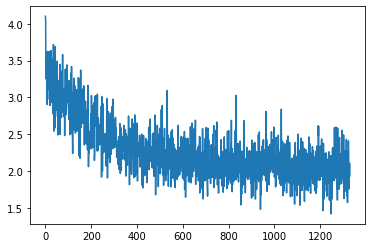

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_loss)

In [ ]:
# device='cuda' if torch.cuda.is_available() else 'cpu'
# seq2seq.to(device)
# seq2seq.eval()
# src = "I am happy"
# src = "[SOS] " + src + " [EOS]" 
# while len(tokenizer(src)['input_ids']) < MAX_LEN:
#   src += " [PAD]"
# src_token = tokenizer(src)['input_ids']
# if len(src_token) < MAX_LEN:
#   src_token = src_token[:MAX_LEN]
# print("len", len(src_token))
# #decode
# src_token = torch.tensor(src_token, dtype=torch.long).reshape(1, -1).to(device)
device='cuda'
src_token, tgt_token = next(iter(train_dataloader))
src_token, decoder_input = src_token.to(device), tgt_token[:, :-1].to(device)
encode_input = seq2seq.encoder(src_token)
state = seq2seq.decoder.init_state(encode_input, encode_input.shape[1])
# tgt = '[SOS] + me too'

In [ ]:
print(decoder_input.shape)
pred, state = seq2seq.decoder(decoder_input, state)
pred = torch.argmax(pred, dim =-1)
print(pred[0]), print([frVocab.idx2word[idx.item()] for idx in pred[0]])

torch.Size([16, 14])
tensor([17,  2, 17, 17, 17,  2, 17, 17, 17,  2,  2, 17,  2, 17],
       device='cuda:0')
['.', '[EOS]', '.', '.', '.', '[EOS]', '.', '.', '.', '[EOS]', '[EOS]', '.', '[EOS]', '.']


(None, None)

In [ ]:
print([frVocab.idx2word[idx.item()] for idx in decoder_input[0]])

['[BOS]', 'ma', 'femme', 'est', 'bon', 'imprésario', '.', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
def inference(model, src, device='cuda' if torch.cuda.is_available() else 'cpu'):
  model.to(device)
  model.eval()
  src = "[SOS] " + src + " [EOS]" 
  while len(tokenizer(src)['input_ids']) < MAX_LEN:
    src += " [PAD]"
  src_token = tokenizer(src)['input_ids']
  if len(src_token) < MAX_LEN:
    src_token = src_token[:MAX_LEN]
  print("len", len(src_token))
  #decode
  src_token = torch.tensor(src_token, dtype=torch.long).reshape(1, -1).to(device)
  encode_input = model.encoder(src_token)
  state = model.decoder.init_state(encode_input, encode_input.shape[1])
  tgt = '[SOS]'
  for i in range(MAX_LEN):
    decoder_input = torch.tensor(tokenizer(tgt)['input_ids'], dtype=torch.long)[1:-1].reshape(1, -1).to(device)
    print(decoder_input.shape)
    pred, state = model.decoder(decoder_input, state)
    pred = torch.argmax(pred[-1], dim =-1)
    print("pred", pred[-1].item())
    tgt += " " + tokenizer.decode(pred[-1], dim =-1) 
    print(tgt)
    
inference(seq2seq, "today is good")

len 20
torch.Size([1, 1])
pred 28997
[SOS] [EOS]
torch.Size([1, 2])
pred 28997
[SOS] [EOS] [EOS]
torch.Size([1, 3])
pred 28997
[SOS] [EOS] [EOS] [EOS]
torch.Size([1, 4])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS]
torch.Size([1, 5])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS] [EOS]
torch.Size([1, 6])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS]
torch.Size([1, 7])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS]
torch.Size([1, 8])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS]
torch.Size([1, 9])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS]
torch.Size([1, 10])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS]
torch.Size([1, 11])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS]
torch.Size([1, 12])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS]
torch.Size([1, 13])
pred 28997
[SOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS]

In [ ]:
tokenizer.convert_ids_to_tokens(13124)

'##nton'

In [ ]:
a = torch.tensor(3).cuda()
b = torch.tensor(3)

In [ ]:
a.masked_fill(b > 0, 1)

RuntimeError: ignored